## Assessment of damage associated with Russia's invasion of Ukraine in 2022

Download all libraries needed for this project

In [1]:
import pandas as pd
import numpy as np
import folium as F
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from math import log10, floor

# print('Matplotlib version: ', mpl.__version__)
# print(plt.style.available)
mpl.style.use(['ggplot'])

Read the CSV files into a Pandas DataFrame

In [2]:
russian_personnel = pd.read_csv('../input/2022-ukraine-russian-war/russia_losses_personnel.csv')
russian_equipment = pd.read_csv('../input/2022-ukraine-russian-war/russia_losses_equipment.csv')

### Let's start by getting a basic understanding of the DataFrame and cleaning the data

In [3]:
russian_personnel.head(10)

,date,day,personnel,personnel*,POW
0,2022-02-25,2,2800,about,0
1,2022-02-26,3,4300,about,0
2,2022-02-27,4,4500,about,0
3,2022-02-28,5,5300,about,0
4,2022-03-01,6,5710,about,200
5,2022-03-02,7,5840,about,200
6,2022-03-03,8,9000,about,200
7,2022-03-04,9,9166,about,200
8,2022-03-05,10,10000,about,216
9,2022-03-06,11,11000,about,232


In [4]:
#remove confusing columns and set index for sorting by date.
russian_personnel.drop(['personnel', 'personnel*'], axis=1, inplace=True)
russian_personnel.set_index('date', inplace=True)
russian_personnel.info()
russian_personnel.head()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 2022-02-25 to 2022-04-24
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   day     59 non-null     int64
 1   POW     59 non-null     int64
dtypes: int64(2)
memory usage: 1.4+ KB


,day,POW
date,,
2022-02-25,2,0
2022-02-26,3,0
2022-02-27,4,0
2022-02-28,5,0
2022-03-01,6,200


In [5]:
russian_equipment.head(10)

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system
0,2022-02-25,2,10,7,80,516,49,4,100,60,0,2,0,NaN,NaN
1,2022-02-26,3,27,26,146,706,49,4,130,60,2,2,0,NaN,NaN
2,2022-02-27,4,27,26,150,706,50,4,130,60,2,2,0,NaN,NaN
3,2022-02-28,5,29,29,150,816,74,21,291,60,3,2,5,NaN,NaN
4,2022-03-01,6,29,29,198,846,77,24,305,60,3,2,7,NaN,NaN
5,2022-03-02,7,30,31,211,862,85,40,355,60,3,2,9,NaN,NaN
6,2022-03-03,8,30,31,217,900,90,42,374,60,3,2,11,NaN,NaN
7,2022-03-04,9,33,37,251,939,105,50,404,60,3,2,18,NaN,NaN
8,2022-03-05,10,39,40,269,945,105,50,409,60,3,2,19,NaN,NaN
9,2022-03-06,11,44,48,285,985,109,50,447,60,4,2,21,NaN,NaN


In [6]:
#fill empty spaces in Dataframe with zeroes and set index for sorting by date.
russian_equipment = russian_equipment.fillna(0)
russian_equipment.set_index('date', inplace=True)
russian_equipment.info()
russian_equipment.head()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 2022-02-25 to 2022-04-24
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   day                    59 non-null     int64  
 1   aircraft               59 non-null     int64  
 2   helicopter             59 non-null     int64  
 3   tank                   59 non-null     int64  
 4   APC                    59 non-null     int64  
 5   field artillery        59 non-null     int64  
 6   MRL                    59 non-null     int64  
 7   military auto          59 non-null     int64  
 8   fuel tank              59 non-null     int64  
 9   drone                  59 non-null     int64  
 10  naval ship             59 non-null     int64  
 11  anti-aircraft warfare  59 non-null     int64  
 12  special equipment      59 non-null     float64
 13  mobile SRBM system     59 non-null     float64
dtypes: float64(2), int64(12)
memory usage: 6.9+ KB


,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system
date,,,,,,,,,,,,,,
2022-02-25,2,10,7,80,516,49,4,100,60,0,2,0,0.0,0.0
2022-02-26,3,27,26,146,706,49,4,130,60,2,2,0,0.0,0.0
2022-02-27,4,27,26,150,706,50,4,130,60,2,2,0,0.0,0.0
2022-02-28,5,29,29,150,816,74,21,291,60,3,2,5,0.0,0.0
2022-03-01,6,29,29,198,846,77,24,305,60,3,2,7,0.0,0.0


In [7]:
#Change all numberic data to integer.
russian_equipment = russian_equipment.astype({'special equipment':np.int64, 'mobile SRBM system':np.int64})
russian_equipment.info()


<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 2022-02-25 to 2022-04-24
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   day                    59 non-null     int64
 1   aircraft               59 non-null     int64
 2   helicopter             59 non-null     int64
 3   tank                   59 non-null     int64
 4   APC                    59 non-null     int64
 5   field artillery        59 non-null     int64
 6   MRL                    59 non-null     int64
 7   military auto          59 non-null     int64
 8   fuel tank              59 non-null     int64
 9   drone                  59 non-null     int64
 10  naval ship             59 non-null     int64
 11  anti-aircraft warfare  59 non-null     int64
 12  special equipment      59 non-null     int64
 13  mobile SRBM system     59 non-null     int64
dtypes: int64(14)
memory usage: 6.9+ KB


### Problem 1
##### Visually represent the country being invaded.

In [8]:
## Coordinates as at 03/31/2021
ukraine_latitude = 48.383022 
ukrain_longitude = 31.1828699
ukraine_map = F.Map(location=[ukraine_latitude, ukrain_longitude], tiles="Stamen Terrain", zoom_start=6.3)

kiev = F.map.FeatureGroup()

kiev_latitude =50.4500336
kiev_longitude =30.5241361
kiev.add_child(F.features.CircleMarker([kiev_latitude, kiev_longitude], radius=5, color="blue", fill_color="blue"))
ukraine_map.add_child(kiev)

F.Marker([kiev_latitude, kiev_longitude], popup="Ukraine's Capital").add_to(ukraine_map)

ukraine_map

### Problem 2

##### Show the total Prisoners of War per day recorded in the Personel table.


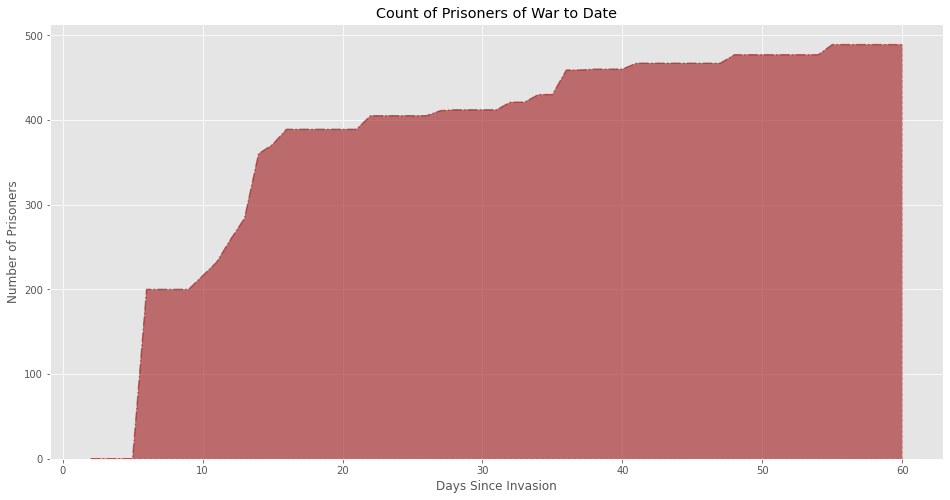

In [9]:
pow_data = russian_personnel[["day", "POW"]]
pow_data.reset_index('date', inplace=True)
pow_data.plot(kind='area', x='day', y='POW', color='brown', alpha =.65, figsize=(16,8), legend=False, linestyle="-.")
plt.title('Count of Prisoners of War to Date')
plt.xlabel('Days Since Invasion')
plt.ylabel('Number of Prisoners') 
plt.show()

### Problem 3
##### What is the daily change in POW and Total POW?

In [10]:
last = 0
increase = []

for i in (pow_data['POW'].values):
    count = i - last
    increase.append(count)
    last = i
    
pow_data['Daily_Increase_in_Prisoners_of_War'] = increase

pow_data_ = pow_data[['day', 'POW', 'Daily_Increase_in_Prisoners_of_War']].set_index('day')
pow_data_.rename(columns={'POW':'Daily_Total_Prisoners_of_War'}, inplace=True)
pow_data_

,Daily_Total_Prisoners_of_War,Daily_Increase_in_Prisoners_of_War
day,,
2,0,0
3,0,0
4,0,0
5,0,0
6,200,200
7,200,0
8,200,0
9,200,0
10,216,16


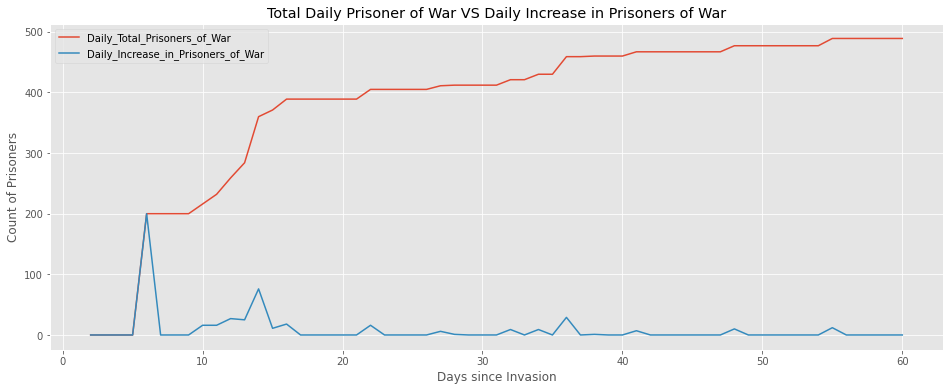

In [11]:
pow_data_.plot(figsize=(16,6))
plt.xlabel('Days since Invasion')
plt.ylabel('Count of Prisoners')
plt.title("Total Daily Prisoner of War VS Daily Increase in Prisoners of War")
plt.show()

### Problem 4

##### Visualize the daily change in POW.

       Daily_Total_Prisoners_of_War  Daily_Increase_in_Prisoners_of_War
count                     59.000000                           59.000000
mean                     381.050847                            8.288136
std                      132.555574                           28.046790
min                        0.000000                            0.000000
25%                      389.000000                            0.000000
50%                      412.000000                            0.000000
75%                      467.000000                            6.500000
max                      489.000000                          200.000000


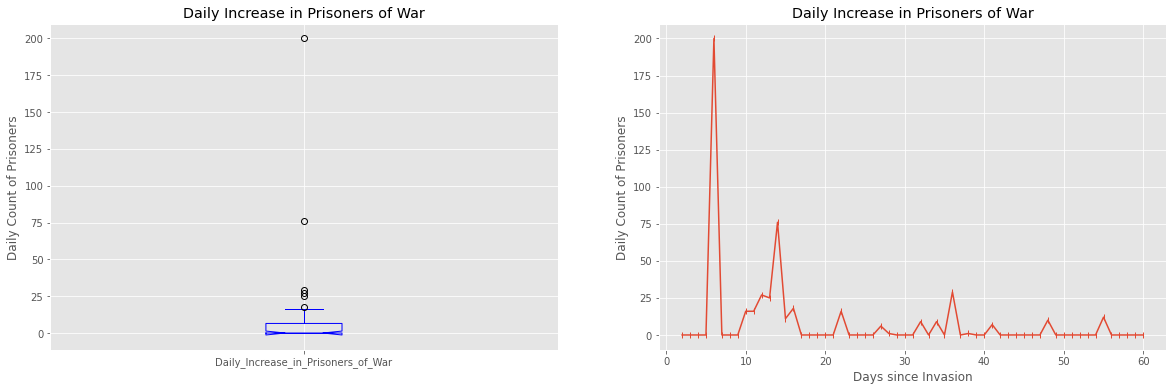

In [12]:
print(pow_data_.describe())

fig = plt.figure()
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

# Subplot 1: Box plot
pow_data_['Daily_Increase_in_Prisoners_of_War'].plot(kind='box', color='blue', figsize=(20, 12), ax=ax0, notch=True) 
ax0.set_title('Daily Increase in Prisoners of War')
ax0.set_ylabel('Daily Count of Prisoners')

# # Subplot 2: Line plot
pow_data_['Daily_Increase_in_Prisoners_of_War'].plot(kind='line', figsize=(20,6), ax=ax1, marker="|")
ax1.set_xlabel('Days since Invasion')
ax1.set_ylabel('Daily Count of Prisoners')
ax1.set_title("Daily Increase in Prisoners of War")

plt.show()

### Problem 5

##### What Is the total daily loss for all equipment?


In [13]:
daily_total_equip_loss = russian_equipment.reset_index('date')
daily_total_equip_loss.drop(columns={'date'}, inplace=True)
daily_total_equip_loss.set_index('day', inplace=True)
daily_total_equip_loss['DailyTotalLoss'] = pd.DataFrame(daily_total_equip_loss.sum(axis=1))
daily_total_equip_loss[['DailyTotalLoss']]

,DailyTotalLoss
day,
2,828
3,1152
4,1157
5,1480
6,1580
7,1688
8,1760
9,1902
10,1941


### Problem 6
##### Create a word map visual to show the equipments with the highest percentage loss in total equipment loss.

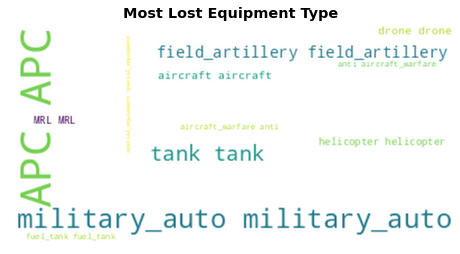

In [14]:
# Get the most recent loss data
total = int(daily_total_equip_loss.iloc[-1: , -1:].values)

total_loss = daily_total_equip_loss.iloc[-1: , :-1]
total_loss.reset_index(inplace=True)
total_loss = pd.DataFrame(total_loss.drop('day', axis=1).transpose()).reset_index()
total_loss.rename(columns={'index':'Equipment', 0:'Count'}, inplace=True)
total_loss.set_index('Equipment', inplace=True)
total_loss.rename(index={'field artillery':'field_artillery','military auto':'military_auto', 'fuel tank':'fuel_tank',
                         'naval ship':'naval_ship', 'anti-aircraft warfare':'anti-aircraft_warfare', 
                         'special equipment':'special_equipment', 'mobile SRBM system':'mobile_SRBM_system'}, inplace=True)

# duplicate equipment name based on how much they contribute to total loss
word_string=""
max_words = 26000
for equipment in total_loss.index:
     times_repeat = int(total_loss.loc[equipment, 'Count']/total * max_words)
     word_string = word_string + ((equipment + " ") * times_repeat)

# create word cloud
word_cloud = WordCloud(background_color = 'white').generate(word_string)

# Display cloud
plt.figure(figsize=(8,8))
plt.imshow(word_cloud, interpolation='bessel')
plt.title('Most Lost Equipment Type', fontweight='bold')
plt.axis('off')
plt.show()


### Problem 7

##### How much equipment did Russia lose in the first 5 days of the invasion?

In [15]:
daily_total_equip_loss.head(4).transpose()

day,2,3,4,5
aircraft,10,27,27,29
helicopter,7,26,26,29
tank,80,146,150,150
APC,516,706,706,816
field artillery,49,49,50,74
MRL,4,4,4,21
military auto,100,130,130,291
fuel tank,60,60,60,60
drone,0,2,2,3
naval ship,2,2,2,2


### Problem 8

##### What is the most recent count of equipment loss?

In [16]:
daily_total_equip_loss.tail().transpose()

day,56,57,58,59,60
aircraft,171,172,176,177,179
helicopter,150,151,153,154,154
tank,815,829,838,854,873
APC,2087,2118,2162,2205,2238
field artillery,391,393,397,403,408
MRL,136,136,138,143,147
military auto,1504,1508,1523,1543,1557
fuel tank,76,76,76,76,76
drone,165,166,172,182,191
naval ship,8,8,8,8,8


### Problem 9

##### Is there any correlation between the POW and equipment loss?


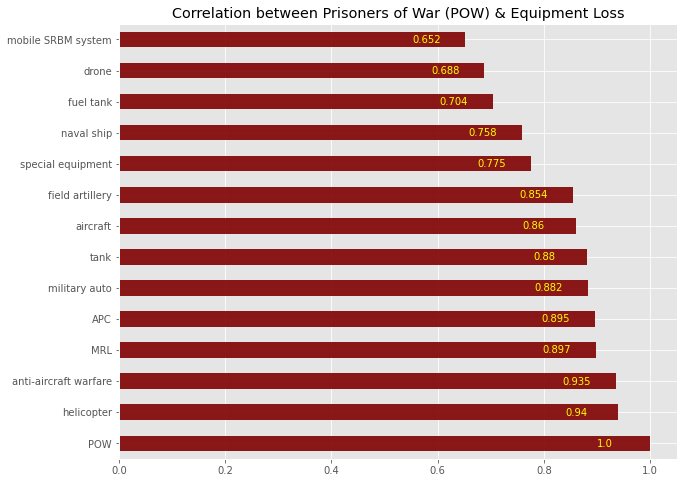

In [17]:
def round_sig(x, sig=3):
    return round(x, sig-int(floor(log10(abs(x))))-1)

merge = pd.merge(russian_equipment, russian_personnel).drop(['day'], axis=1)
merged = merge.corr()['POW'].sort_values(ascending=False)

merged.plot.barh(title='Correlation between Prisoners of War (POW) & Equipment Loss',
                 figsize=(10,8),alpha=.9,color='maroon')
for index, value in enumerate(merged):
    value = round_sig(value)
    label = format(value)
    plt.annotate(label, xy=(value-.1, index-.1), color='yellow')

### Problem 10

##### What inferences can you make from the relationship between POW and Equipment loss?


In [18]:
merged.describe()


count    14.000000
mean      0.837230
std       0.104814
min       0.652166
25%       0.762491
50%       0.869925
75%       0.896677
max       1.000000
Name: POW, dtype: float64

In [19]:
m = merged.describe()
k = merged.keys()
v = merged.values

print(f"There is a very strong, positive, direct corralation between Prisoners of War(POW) and overall Equipment Loss. \
As the POW increases, so does the overall equipment loss. The strength in correlation, ranges from {round_sig(v[1])} \
({k[1]}) to {round_sig(v[-1])} ({k[-1]}). The median correlation is {round_sig(m[-3])} and it falls between {k[6]} and \
{k[7]}. The standard deviation is {round_sig(m[2])} which indicated that the there is not much variability in the data; \
all points are close to the mean. It is then valid to conclude that as the invasion continues, and POW increases so will \
overall equipment loss especially the loss of {k[1]} by at least {round_sig(m[3])}.")


There is a very strong, positive, direct corralation between Prisoners of War(POW) and overall Equipment Loss. As the POW increases, so does the overall equipment loss. The strength in correlation, ranges from 0.94 (helicopter) to 0.652 (mobile SRBM system). The median correlation is 0.87 and it falls between tank and aircraft. The standard deviation is 0.105 which indicated that the there is not much variability in the data; all points are close to the mean. It is then valid to conclude that as the invasion continues, and POW increases so will overall equipment loss especially the loss of helicopter by at least 0.652.


<!-- It should be noted that the strongest correlation exists not between the equipmet type with the highest loss({}) but with the type that had the ({}) highest loss. -->